              precision    recall  f1-score   support

          ST       0.64      0.84      0.73    144938
          WK       0.80      0.58      0.68    144938
          TR       0.57      0.62      0.59    144938
          BD       0.81      0.68      0.74    144938
          SQ       0.90      0.94      0.92    144938

    accuracy                           0.73    724690
   macro avg       0.74      0.73      0.73    724690
weighted avg       0.74      0.73      0.73    724690

Accuracy:
0.7322151540658765


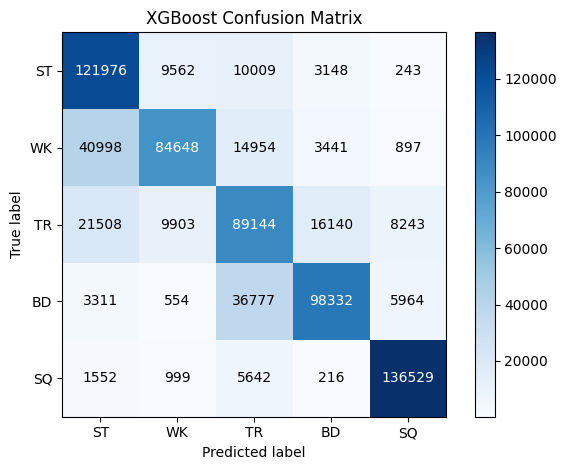

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 定义要处理的主题
train_subjects = ['Carpenter1', 'Carpenter2', 'Rebar1', 'Rebar2', 'Rebar3']
test_subjects = ['Masonry1', 'Masonry2']

def load_and_preprocess_data(subject, label_mapping):
    """
    加载并预处理指定主题的数据。
    
    参数:
        subject (str): 主题名称
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 处理后的特征X和标签y
    """
    # 读取数据
    df = pd.read_csv(f'../{subject}.csv', low_memory=False)
    
    # 清除空值行
    df_cleaned = df.dropna()
    
    # 转换 'Label_2' 列为数值类型
    df_cleaned.loc[:, 'Label_2'] = pd.to_numeric(df_cleaned['Label_2'], errors='coerce')
    
    # 只选取前八个动作
    df_cleaned = df_cleaned[df_cleaned['Label_2'] <= 8]
    
    # 重新编码标签
    df_cleaned.loc[:, 'Label_2'] = df_cleaned['Label_2'].map(label_mapping)

    # 同步 xd 和 kd 的记录
    df_xd = df_cleaned[df_cleaned['position'] == 'xd'].copy()
    df_kd = df_cleaned[df_cleaned['position'] == 'kd'].copy()

    row_len = min(len(df_xd), len(df_kd))

    # 获取列名并添加后缀以避免重复
    columns_xd = [f'{col}_xd' for col in df_xd.columns]
    columns_kd = [f'{col}_kd' for col in df_kd.columns]

    # 重命名列
    df_xd.columns = columns_xd
    df_kd.columns = columns_kd

    df_xd = df_xd.iloc[:row_len-1, :]
    df_kd = df_kd.iloc[:row_len-1, :]

    df_xd = df_xd.reset_index(drop=True)
    df_kd = df_kd.reset_index(drop=True)

    # 合并两个DataFrame
    paired_df = pd.concat([df_kd, df_xd], axis=1)
    paired_df = paired_df.loc[:, ~paired_df.columns.duplicated()]

    # 删除不需要的列
    columns_to_drop = ['seconds_elapsed_xd','seconds_elapsed_kd', 'position_xd','position_kd', 'time_xd', 'time_kd', 'Real Time_xd', 'Real Time_kd']
    paired_df = paired_df.drop(columns=columns_to_drop)
    
    X = paired_df.drop(['Label_2_xd'], axis=1)
    y = paired_df['Label_2_xd']

    X = X.drop(columns=['Subject_kd', 'Subject_xd'])

    # 确保所有特征都是数值类型
    for i in X.columns:
        if X[i].dtype == 'object':
            X[i] = pd.to_numeric(X[i], errors='raise')

    # 设置窗口大小并应用滑动窗口聚合
    window_size = 30
    X_rolled = X.rolling(window=window_size, min_periods=1).mean()
    y_rolled = y.rolling(window=window_size, min_periods=1).apply(
        lambda x: x.mode().iloc[0] if not x.isnull().all() else None, raw=False
    )

    # 删除没有完整窗口的数据
    X_rolled = X_rolled.dropna().reset_index(drop=True)
    y_rolled = y_rolled.dropna().reset_index(drop=True)

    # 使用SMOTE处理类别不平衡
    smote = SMOTE(random_state=42)
    X_final, y_final = smote.fit_resample(X_rolled, y_rolled)

    # 将y标签修改成int
    y_final = y_final.astype(int) - 1

    return X_final, y_final

def prepare_datasets(train_subjects, test_subjects, label_mapping):
    """
    准备训练集和测试集。
    
    参数:
        train_subjects (list of str): 训练集主题列表
        test_subjects (list of str): 测试集主题列表
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 训练集特征、训练集标签、测试集特征、测试集标签
    """
    all_train_data = []
    all_test_data = []

    for subject in train_subjects + test_subjects:
        X, y = load_and_preprocess_data(subject, label_mapping)
        if subject in train_subjects:
            all_train_data.append((X, y))
        else:
            all_test_data.append((X, y))

    # 合并所有训练集和测试集数据
    X_train = pd.concat([x for x, _ in all_train_data], axis=0).values
    y_train = pd.concat([y for _, y in all_train_data], axis=0).values
    X_test = pd.concat([x for x, _ in all_test_data], axis=0).values
    y_test = pd.concat([y for _, y in all_test_data], axis=0).values

    return X_train, y_train, X_test, y_test

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path):
    """
    绘制混淆矩阵图。
    
    参数:
        y_true (array-like): 真实标签
        y_pred (array-like): 预测标签
        labels (list of str): 分类标签
        title (str): 图标题
        save_path (str): 保存图片路径
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, dpi=300)

# 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

# 训练XGBoost分类器
model = XGBClassifier()
model.fit(X_train, y_train)

# 使用测试数据预测类别
y_pred = model.predict(X_test)

# 输出评估结果
print(classification_report(y_test, y_pred, target_names=['ST', 'WK', 'TR', 'BD', 'SQ']))
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

# 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, ['ST', 'WK', 'TR', 'BD', 'SQ'], 'XGBoost Confusion Matrix', 'XGBoost_Conclusion.png')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 定义要处理的主题
train_subjects = ['Carpenter1', 'Carpenter2', 'Rebar1', 'Rebar2', 'Rebar3']
test_subjects = ['Masonry1', 'Masonry2']

def load_and_preprocess_data(subject, label_mapping):
    """
    加载并预处理指定主题的数据。
    
    参数:
        subject (str): 主题名称
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 处理后的特征X和标签y
    """
    # 读取数据
    df = pd.read_csv(f'../{subject}.csv', low_memory=False)
    
    # 清除空值行
    df_cleaned = df.dropna()
    
    # 转换 'Label_2' 列为数值类型
    df_cleaned.loc[:, 'Label_2'] = pd.to_numeric(df_cleaned['Label_2'], errors='coerce')
    
    # 只选取前八个动作
    df_cleaned = df_cleaned[df_cleaned['Label_2'] <= 8]
    
    # 重新编码标签
    df_cleaned.loc[:, 'Label_2'] = df_cleaned['Label_2'].map(label_mapping)

    # 同步 xd 和 kd 的记录
    df_xd = df_cleaned[df_cleaned['position'] == 'xd'].copy()
    df_kd = df_cleaned[df_cleaned['position'] == 'kd'].copy()

    row_len = min(len(df_xd), len(df_kd))

    # 获取列名并添加后缀以避免重复
    columns_xd = [f'{col}_xd' for col in df_xd.columns]
    columns_kd = [f'{col}_kd' for col in df_kd.columns]

    # 重命名列
    df_xd.columns = columns_xd
    df_kd.columns = columns_kd

    df_xd = df_xd.iloc[:row_len-1, :]
    df_kd = df_kd.iloc[:row_len-1, :]

    df_xd = df_xd.reset_index(drop=True)
    df_kd = df_kd.reset_index(drop=True)

    # 合并两个DataFrame
    paired_df = pd.concat([df_kd, df_xd], axis=1)
    paired_df = paired_df.loc[:, ~paired_df.columns.duplicated()]

    # 删除不需要的列
    columns_to_drop = ['seconds_elapsed_xd','seconds_elapsed_kd', 'position_xd','position_kd', 'time_xd', 'time_kd', 'Real Time_xd', 'Real Time_kd']
    paired_df = paired_df.drop(columns=columns_to_drop)
    
    X = paired_df.drop(['Label_2_xd'], axis=1)
    y = paired_df['Label_2_xd']

    X = X.drop(columns=['Subject_kd', 'Subject_xd'])

    # 确保所有特征都是数值类型
    for i in X.columns:
        if X[i].dtype == 'object':
            X[i] = pd.to_numeric(X[i], errors='raise')

    # 设置窗口大小并应用滑动窗口聚合
    window_size = 30
    X_rolled = X.rolling(window=window_size, min_periods=1).mean()
    y_rolled = y.rolling(window=window_size, min_periods=1).apply(
        lambda x: x.mode().iloc[0] if not x.isnull().all() else None, raw=False
    )

    # 删除没有完整窗口的数据
    X_rolled = X_rolled.dropna().reset_index(drop=True)
    y_rolled = y_rolled.dropna().reset_index(drop=True)

    # 使用SMOTE处理类别不平衡
    smote = SMOTE(random_state=42)
    X_final, y_final = smote.fit_resample(X_rolled, y_rolled)

    # 将y标签修改成int
    y_final = y_final.astype(int) - 1

    return X_final, y_final

def prepare_datasets(train_subjects, test_subjects, label_mapping):
    """
    准备训练集和测试集。
    
    参数:
        train_subjects (list of str): 训练集主题列表
        test_subjects (list of str): 测试集主题列表
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 训练集特征、训练集标签、测试集特征、测试集标签
    """
    all_train_data = []
    all_test_data = []

    for subject in train_subjects + test_subjects:
        X, y = load_and_preprocess_data(subject, label_mapping)
        if subject in train_subjects:
            all_train_data.append((X, y))
        else:
            all_test_data.append((X, y))

    # 合并所有训练集和测试集数据
    X_train = pd.concat([x for x, _ in all_train_data], axis=0).values
    y_train = pd.concat([y for _, y in all_train_data], axis=0).values
    X_test = pd.concat([x for x, _ in all_test_data], axis=0).values
    y_test = pd.concat([y for _, y in all_test_data], axis=0).values

    return X_train, y_train, X_test, y_test

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path):
    """
    绘制混淆矩阵图。
    
    参数:
        y_true (array-like): 真实标签
        y_pred (array-like): 预测标签
        labels (list of str): 分类标签
        title (str): 图标题
        save_path (str): 保存图片路径
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, dpi=300)

# 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

# 训练XGBoost分类器
model = XGBClassifier()
model.fit(X_train, y_train)

# 使用测试数据预测类别
y_pred = model.predict(X_test)

# 输出评估结果
print(classification_report(y_test, y_pred, target_names=['ST', 'WK', 'TR', 'BD', 'SQ']))
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

# 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, ['ST', 'WK', 'TR', 'BD', 'SQ'], 'XGBoost Confusion Matrix', 'XGBoost_Conclusion.png')

测试

In [11]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shap

def plot_training_history(evaluation_results):
    """
    绘制训练历史曲线图。
    
    参数:
        evaluation_results (dict): 训练过程中的评估结果
    """
    # 获取迭代次数
    epochs = len(evaluation_results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    # 创建图表
    fig, ax = plt.subplots()
    
    # 绘制训练集和验证集的损失曲线
    ax.plot(x_axis, evaluation_results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, evaluation_results['validation_1']['mlogloss'], label='Test')
    
    # 添加图例
    ax.legend()
    
    # 设置标签
    plt.ylabel('Multi-class Log Loss')
    plt.title('XGBoost Multi-class Log Loss')
    
    # 保存图表
    plt.savefig('training_mlogloss.png', dpi=300)
    
    # 显示图表
    plt.show()

def visualize_model(model, feature_names):
    """
    可视化模型特征重要性。
    
    参数:
        model (XGBClassifier): 训练好的XGBoost分类器
        feature_names (list of str): 特征名称列表
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_importance(model, max_num_features=10, height=0.5, ax=ax)
    plt.savefig('feature_importance.png', dpi=300)

def explain_with_shap(model, X_train, X_test):
    """
    使用SHAP解释模型预测。
    
    参数:
        model (XGBClassifier): 训练好的XGBoost分类器
        X_train (DataFrame): 训练数据
        X_test (DataFrame): 测试数据
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.savefig('shap_summary_bar.png', dpi=300)
    shap.summary_plot(shap_values, X_train, show=False)
    plt.savefig('shap_summary_dot.png', dpi=300)

# 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

# 训练XGBoost分类器，并记录训练过程
model = XGBClassifier(eval_metric='mlogloss', early_stopping_rounds=10)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# 获取训练过程中的评估结果
evaluation_results = model.evals_result()


[0]	validation_0-mlogloss:1.06747	validation_1-mlogloss:1.24273
[1]	validation_0-mlogloss:0.79773	validation_1-mlogloss:1.07614
[2]	validation_0-mlogloss:0.62653	validation_1-mlogloss:0.96277
[3]	validation_0-mlogloss:0.50782	validation_1-mlogloss:0.90019
[4]	validation_0-mlogloss:0.42235	validation_1-mlogloss:0.84681
[5]	validation_0-mlogloss:0.35776	validation_1-mlogloss:0.80972
[6]	validation_0-mlogloss:0.30718	validation_1-mlogloss:0.79024
[7]	validation_0-mlogloss:0.26999	validation_1-mlogloss:0.78096
[8]	validation_0-mlogloss:0.23862	validation_1-mlogloss:0.77218
[9]	validation_0-mlogloss:0.21458	validation_1-mlogloss:0.76752
[10]	validation_0-mlogloss:0.19520	validation_1-mlogloss:0.76115
[11]	validation_0-mlogloss:0.17783	validation_1-mlogloss:0.75447
[12]	validation_0-mlogloss:0.16345	validation_1-mlogloss:0.76446
[13]	validation_0-mlogloss:0.15080	validation_1-mlogloss:0.75766
[14]	validation_0-mlogloss:0.14046	validation_1-mlogloss:0.76103
[15]	validation_0-mlogloss:0.13206	

In [ ]:
from sklearn.model_selection import GridSearchCV

# 定义超参数搜索空间
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.001, 0.01, 0.1],  # L1正则化
    'reg_lambda': [0, 0.001, 0.01, 0.1]   # L2正则化
}

# 初始化XGBoost分类器
xgb = XGBClassifier(eval_metric='mlogloss', early_stopping_rounds=10)

# # 自定义fit方法以支持早停
# def fit_with_early_stopping(estimator, X, y):
#     return estimator.fit(X, y, eval_set=[(X, y), (X_test, y_test)], verbose=True)

# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    # n_jobs=-1,
    verbose=2,
    # fit_params={'eval_set': [(X_train, y_train), (X_test, y_test)]}  # 传递早停所需的eval_set
)
grid_search.fit(X_train, y_train)  # 使用默认的fit方法，这里不直接调用自定义的fit_with_early_stopping
# fit_with_early_stopping(grid_search.estimator, X_train, y_train)

# 输出最佳参数
print("Best parameters found: ", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True, early_stopping_rounds=10)


In [ ]:

from xgboost import XGBClassifier

# 直接设置一组超参数
params = {
    'n_estimators': 200,  # 树的数量
    'max_depth': 4,       # 树的最大深度
    'learning_rate': 0.1, # 学习率
    'min_child_weight': 3, # 最小叶子节点样本权重和
    'subsample': 0.8,     # 随机采样比例
    'colsample_bytree': 0.9, # 列采样比例
    'gamma': 0.1,         # 叶子节点分裂所需的最小损失减少
    'reg_alpha': 0.5,    # L1 正则化项
    'reg_lambda': 0.5,    # L2 正则化项
    'eval_metric': 'mlogloss', # 评价指标
    'early_stopping_rounds': 10, # 早停轮数
}

# 初始化XGBoost分类器
xgb = XGBClassifier(**params)

# 训练模型，并使用早停机制
xgb.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=True)

# 使用训练好的模型进行预测（可选）
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model: {accuracy:.4f}")

[0]	validation_0-mlogloss:1.46713
[1]	validation_0-mlogloss:1.36614
[2]	validation_0-mlogloss:1.27725
[3]	validation_0-mlogloss:1.20124
[4]	validation_0-mlogloss:1.15208
[5]	validation_0-mlogloss:1.09972
[6]	validation_0-mlogloss:1.05577
[7]	validation_0-mlogloss:1.01255
[8]	validation_0-mlogloss:0.97646
[9]	validation_0-mlogloss:0.94686
[10]	validation_0-mlogloss:0.92220
[11]	validation_0-mlogloss:0.89679
[12]	validation_0-mlogloss:0.87191
[13]	validation_0-mlogloss:0.85146
[14]	validation_0-mlogloss:0.83130
[15]	validation_0-mlogloss:0.81451
[16]	validation_0-mlogloss:0.79989
[17]	validation_0-mlogloss:0.78674
[18]	validation_0-mlogloss:0.77521
[19]	validation_0-mlogloss:0.76917
[20]	validation_0-mlogloss:0.76140
[21]	validation_0-mlogloss:0.75442
[22]	validation_0-mlogloss:0.74587
[23]	validation_0-mlogloss:0.73896
[24]	validation_0-mlogloss:0.73735
[25]	validation_0-mlogloss:0.73085
[26]	validation_0-mlogloss:0.72533
[27]	validation_0-mlogloss:0.72096
[28]	validation_0-mlogloss:0.7

In [ ]:
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# # 定义XGBoost参数
# xgb_params = {
#     'n_estimators': 200,
#     'max_depth': 4,
#     'learning_rate': 0.1,
#     'min_child_weight': 3,
#     'subsample': 0.8,
#     'colsample_bytree': 0.9,
#     'gamma': 0.1,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.1,
#     'eval_metric': 'mlogloss',
#     'early_stopping_rounds': 10
# }

# # 定义LightGBM参数
# lgbm_params = {
#     'n_estimators': 200,
#     'max_depth': 4,
#     'learning_rate': 0.1,
#     'min_child_samples': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.9,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.1,
#     'objective': 'multiclass',
#     'num_class': 5,  # 根据你的类别数调整
#     # 'early_stopping_rounds': 10
# }

# # 定义CatBoost参数
# catboost_params = {
#     'iterations': 200,
#     'depth': 4,
#     'learning_rate': 0.1,
#     'l2_leaf_reg': 3,
#     'bagging_temperature': 0.9,
#     'random_strength': 0.1,
#     'one_hot_max_size': 2,
#     'loss_function': 'MultiClass',
#     'eval_metric': 'Accuracy',
#     'early_stopping_rounds': 10,
#     'verbose': 0  # 设置verbose为0以减少输出信息
# }

# # 初始化各个模型
# xgb_clf = XGBClassifier(**xgb_params)
# lgbm_clf = LGBMClassifier(**lgbm_params)
# catboost_clf = CatBoostClassifier(**catboost_params)

# # 分别训练每个模型
# xgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)


In [4]:
from lightgbm import LGBMClassifier, early_stopping

# 定义LightGBM参数
lgbm_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'objective': 'multiclass',
    'num_class': 5,  # 根据你的类别数调整
    'force_col_wise': True  # 强制列式多线程
}

# 初始化LightGBM分类器
lgbm_clf = LGBMClassifier(**lgbm_params)

# 定义早停回调
early_stopping_callback = early_stopping(stopping_rounds=10)

# 训练LightGBM模型
lgbm_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='multi_logloss',  # 根据你的任务选择合适的评价指标
    callbacks=[early_stopping_callback],
)

[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 1226020, number of used features: 39
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping,

LGBMClassifier(colsample_bytree=0.9, force_col_wise=True, learning_rate=0.05,
               max_depth=6, n_estimators=500, num_class=5,
               objective='multiclass', reg_alpha=0.01, reg_lambda=0.01,
               subsample=0.8)

In [ ]:

lgbm_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


In [ ]:

# # 创建投票分类器
# voting_clf = VotingClassifier(
#     estimators=[
#         ('xgb', xgb_clf),
#         ('lgbm', lgbm_clf),
#         ('catboost', catboost_clf)
#     ],
#     voting='soft'  # 使用软投票，即基于概率进行投票
# )

# # 即使基础分类器已经训练好，也需要调用 fit 方法
# # 这里可以传递一个较小的数据集，因为只需要初始化内部状态
# voting_clf.fit(X_train, y_train,y_train)

# # 使用训练好的模型进行预测
# y_pred = voting_clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the ensemble model: {accuracy:.4f}")

In [ ]:
# # 使用训练好的模型进行预测（可选）
# y_pred = catboost_clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the best model: {accuracy:.4f}")

In [ ]:

# # 验证最佳模型
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the best model: {accuracy:.4f}")

In [6]:
from catboost import CatBoostClassifier

# 定义CatBoost参数
catboost_params = {
    'iterations': 200,
    'depth': 4,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'bagging_temperature': 0.9,
    'random_strength': 0.1,
    'one_hot_max_size': 2,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 10,
    'verbose': 0  # 设置verbose为0以减少输出信息
}

catboost_clf = CatBoostClassifier(**catboost_params)

catboost_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


In [7]:

# 保存原始模型
catboost_clf.save_model('original_model.cbm')

In [8]:
# 加载预训练的模型
pretrained_model = CatBoostClassifier()
pretrained_model.load_model('original_model.cbm')

# 定义新的 CatBoost 分类器
fine_tuned_model = CatBoostClassifier(
    iterations=100,  # 新的迭代次数
    learning_rate=0.05,  # 较小的学习率
    depth=6,
    loss_function='MultiClass',  # 根据你的任务选择合适的损失函数
    random_seed=42,
    verbose=False  # 关闭日志输出
)

# 使用预训练模型继续训练
fine_tuned_model.fit(
    X_test, y_test,
    eval_set=None,  # 如果不需要验证集，可以设置为 None
    init_model=pretrained_model  # 指定预训练模型
)

# 评估模型
y_pred = fine_tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the fine-tuned model: {accuracy:.4f}")

# 保存微调后的模型
fine_tuned_model.save_model('fine_tuned_model.cbm')

Accuracy of the fine-tuned model: 0.9030


In [ ]:

# 绘制训练历史
plot_training_history(best_model.evals_result())

# 可视化特征重要性
visualize_model(best_model, pd.DataFrame(X_train).columns.tolist())


In [ ]:

# SHAP解释
explain_with_shap(catboost_clf, X_train, X_test)

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True, early_stopping_rounds=10)

# 获取训练过程中的评估结果
evaluation_results = model.evals_result()




d:\python3.9.0\PYTHON\lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.24273
[1]	validation_0-mlogloss:1.07614
[2]	validation_0-mlogloss:0.96277
[3]	validation_0-mlogloss:0.90019
[4]	validation_0-mlogloss:0.84681
[5]	validation_0-mlogloss:0.80972
[6]	validation_0-mlogloss:0.79024
[7]	validation_0-mlogloss:0.78096
[8]	validation_0-mlogloss:0.77218
[9]	validation_0-mlogloss:0.76752
[10]	validation_0-mlogloss:0.76115
[11]	validation_0-mlogloss:0.75447
[12]	validation_0-mlogloss:0.76446


In [ ]:

# 训练XGBoost分类器，并记录训练过程
model = XGBClassifier(eval_metric='mlogloss', early_stopping_rounds=10)


In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=True, early_stopping_rounds=10)

# 获取训练过程中的评估结果
evaluation_results = model.evals_result()

d:\python3.9.0\PYTHON\lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.24273
[1]	validation_0-mlogloss:1.07614
[2]	validation_0-mlogloss:0.96277
[3]	validation_0-mlogloss:0.90019
[4]	validation_0-mlogloss:0.84681
[5]	validation_0-mlogloss:0.80972
[6]	validation_0-mlogloss:0.79024
[7]	validation_0-mlogloss:0.78096
[8]	validation_0-mlogloss:0.77218
[9]	validation_0-mlogloss:0.76752
[10]	validation_0-mlogloss:0.76115
[11]	validation_0-mlogloss:0.75447
[12]	validation_0-mlogloss:0.76446


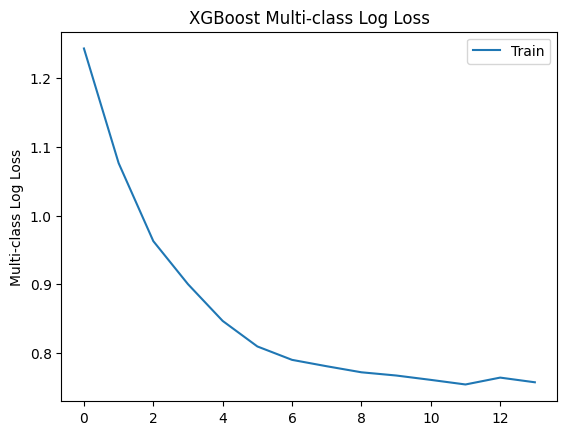

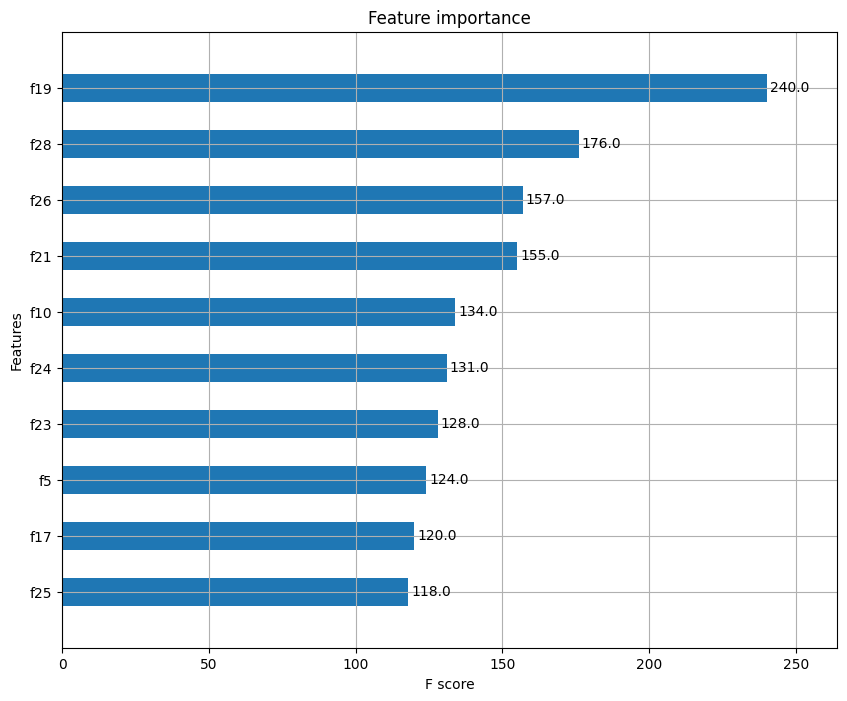

In [ ]:
def plot_training_history(evaluation_results):
    """
    绘制训练历史曲线图。
    
    参数:
        evaluation_results (dict): 训练过程中的评估结果
    """
    # 获取迭代次数
    epochs = len(evaluation_results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    # 创建图表
    fig, ax = plt.subplots()
    
    # 绘制训练集和验证集的损失曲线
    ax.plot(x_axis, evaluation_results['validation_0']['mlogloss'], label='Train')
    
    # 添加图例
    ax.legend()
    
    # 设置标签
    plt.ylabel('Multi-class Log Loss')
    plt.title('XGBoost Multi-class Log Loss')
    
    # 保存图表
    plt.savefig('training_mlogloss.png', dpi=300)
    
    # 显示图表
    plt.show()
# 可视化训练过程
plot_training_history(evaluation_results)

# 可视化模型特征重要性
visualize_model(model, pd.DataFrame(X_train).columns)



              precision    recall  f1-score   support

          ST       0.63      0.82      0.71    144938
          WK       0.85      0.55      0.67    144938
          TR       0.55      0.58      0.57    144938
          BD       0.81      0.78      0.79    144938
          SQ       0.90      0.94      0.92    144938

    accuracy                           0.73    724690
   macro avg       0.75      0.73      0.73    724690
weighted avg       0.75      0.73      0.73    724690

Accuracy:
0.7338917330168762


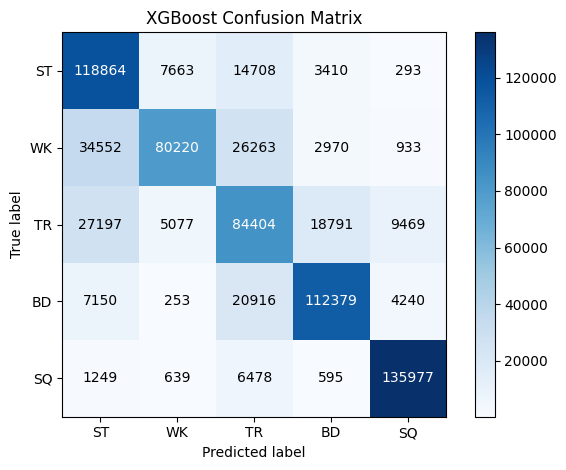

In [9]:

# 使用测试数据预测类别
y_pred = model.predict(X_test)

# 输出评估结果
print(classification_report(y_test, y_pred, target_names=['ST', 'WK', 'TR', 'BD', 'SQ']))
print("Accuracy:")
print(accuracy_score(y_test, y_pred))

# 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, ['ST', 'WK', 'TR', 'BD', 'SQ'], 'XGBoost Confusion Matrix', 'XGBoost_Conclusion.png')


In [ ]:

# 使用SHAP解释模型
explain_with_shap(model, X_train, X_test)